In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

from pysteps.postprocessing.ensemblestats import excprob
from pysteps.visualization import get_colormap
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from pincast_verif.nowcast_plot_tools import plot_image_grid
import pincast_verif.io_tools as io

In [6]:
SAVE = False
DATA_FOLDER = Path("../data")
OUTPUT_FOLDER = DATA_FOLDER / "figures"

dbs = [
    DATA_FOLDER / "deuce_nowcasts" / "deuce-raw-2022-cases.hdf5",
    DATA_FOLDER / "baseline_nowcasts" / "steps-2022-cases.hdf5",
    DATA_FOLDER / "baseline_nowcasts" / "linda-p-2022-cases.hdf5",
    DATA_FOLDER / "baseline_nowcasts" / "measurements-2022-cases.hdf5"
]

case_timestamp = "2022-07-09 15:00:00"

In [4]:
metadata = [io.get_hdf5_metadata(db_path=dbs[i]) for i in range(len(dbs))]

pred = io.load_predictions(
    db_path=dbs[0],
    time_0=case_timestamp,
    leadtimes=metadata[0]["leadtimes"],
    method_name=metadata[0]["method_name"]
    )
obses = io.load_observations(
    db_path=dbs[-1],
    time_0=case_timestamp,
    leadtimes=metadata[0]["leadtimes"],
    method_name=metadata[-1]["method_name"]
)
steps = io.load_predictions(
    db_path=dbs[1],
    time_0=case_timestamp,
    leadtimes=metadata[1]["leadtimes"],
    method_name=metadata[1]["method_name"]
    )
linda_p = io.load_predictions(
    db_path=dbs[2],
    time_0=case_timestamp,
    leadtimes=metadata[2]["leadtimes"],
    method_name=metadata[2]["method_name"]
    )

In [7]:
rand_eps = np.random.normal(size=48)
pred[...,1] = (pred[...,1] + 32.0)**2 # make al STDs to variances starting at 0.0. 
pred_mean = pred[...,0].mean(axis=1)
pred_var = ((pred[...,1]).mean(axis=1)) + pred[...,0].var(axis=1) #mean of al var + ep var
pred_std = np.sqrt(pred_var)
pred_combined = np.stack([pred_mean + e * np.sqrt(pred_var) for e in rand_eps])
pred_combined = np.swapaxes(pred_combined, 0, 1)
pred_combined[pred_combined < -32.0] = -32.0
pred_combined[pred_combined >= 95.0] = 95.0
pred_combined.shape

(12, 48, 512, 512)

In [49]:
pred_mean = pred[...,0].mean(axis=1)
pred_al = np.sqrt((pred[...,1]).mean(axis=1)) 
pred_ep = pred[...,0].std(axis=1)

In [10]:
inputs = io.load_observations(
    db_path=dbs[-1],
    time_0=case_timestamp,
    leadtimes=range(-12,0),
    method_name=metadata[-1]["method_name"]
)

In [50]:
from pysteps.noise import get_method

filter_method, generator_method = get_method("nonparametric")
np_filter = filter_method(inputs)
corr_noise = np.stack([generator_method(np_filter)for _ in range(48)],axis=0)
pred_combined_corr = np.stack([pred_mean + corr_noise[i] * pred_std for i in range(48)],axis=1)
pred_al_corr =  np.stack([pred_mean + corr_noise[i] * pred_al for i in range(48)],axis=1)
pred_ep_corr =  np.stack([pred_mean + corr_noise[i] * pred_ep for i in range(48)],axis=1)
pred_combined_corr[pred_combined_corr < -32.0] = -32.0
pred_combined_corr[pred_combined_corr >= 95.0] = 95.0

pred_al_corr[pred_al_corr < -32.0] = -32.0
pred_al_corr[pred_al_corr >= 95.0] = 95.0

pred_ep_corr[pred_ep_corr < -32.0] = -32.0
pred_ep_corr[pred_ep_corr >= 95.0] = 95.0

In [48]:
steps_mean = steps.mean(axis=1)
steps_std = steps.std(axis=1)

linda_p_mean = np.mean(linda_p, axis=1)
linda_p_std = np.std(linda_p, axis=1)

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj

def proj4_to_cartopy(proj4str):
    proj = pyproj.Proj(proj4str)

    km_proj = {"lon_0": "central_longitude",
               "lat_0": "central_latitude",
               "lat_ts": "true_scale_latitude",
               "x_0": "false_easting",
               "y_0": "false_northing",
               "k": "scale_factor",
               "zone": "zone"}
    km_globe = {'a': "semimajor_axis",
                'b': "semiminor_axis"}
    km_std = {"lat_1": "lat_1",
              "lat_2": "lat_2"}

    kw_proj  = {}
    kw_globe = {}
    kw_std   = {}

    for s in proj.srs.split('+'):
        s = s.split('=')
        if len(s) != 2:
            continue
        k = s[0].strip()
        v = s[1].strip()
        try:
            v = float(v)
        except:
            pass

        if k == "proj":
            if v == "tmerc":
                cl = ccrs.TransverseMercator
            elif v == "laea":
                cl = ccrs.LambertAzimuthalEqualArea
            elif v == "lcc":
                cl = ccrs.LambertConformal
            elif v == "merc":
                cl = ccrs.Mercator
            elif v == "utm":
                cl = ccrs.UTM
            elif v == "stere":
                cl = ccrs.Stereographic
            elif v == "aea":
                cl = ccrs.AlbersEqualArea
            elif v == "somerc":
                raise UnsupportedSomercProjection("unsupported projection: somerc")
            else:
                raise ValueError("unsupported projection: %s" % v)
        elif k in km_proj:
            kw_proj[km_proj[k]] = v
        elif k in km_globe:
            kw_globe[km_globe[k]] = v
        elif k in km_std:
            kw_std[km_std[k]] = v

    globe = None
    if kw_globe:
        globe = ccrs.Globe(**kw_globe)
    if kw_std:
        kw_proj["standard_parallels"] = (kw_std["lat_1"], kw_std["lat_2"])

    if cl.__name__ == "Mercator":
        kw_proj.pop("false_easting",  None)
        kw_proj.pop("false_northing", None)

    return cl(globe=globe, **kw_proj)

from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str, pos="top", x=-0.03, y=0.4, fontsize=10):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    if pos == "top":
        row.set_title(f'{title}\n', fontweight='semibold',x=x,y=y,fontsize=fontsize)
    elif pos == "left":
        row.set_title(f'{title}\n', fontweight='semibold',rotation="vertical",x=x,y=y,fontsize=fontsize)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')


In [14]:
projdef = "+proj=stere +lon_0=25.0 +lat_0=60.0 +lat_ts=60.0 +R=6370997.0 +x_0=320420.66239 +y_0=97694.4330307 +units=m"
projdef = "+proj=stere +a=6371288 +lon_0=25E +lat_0=90N +lat_ts=60 +x_0=380886.310 +y_0=3395677.920 +no_defs"

ll_lon = 19.4
ll_lat = 58.0
ur_lon = 35.2
ur_lat = 70.2


#popular bbox
ll_lon = 18.60
ll_lat = 57.93
ur_lon = 34.903
ur_lat = 69.005

proj = pyproj.Proj(projdef)
crs = proj4_to_cartopy(projdef)

cartopy_scale = "50m"

In [15]:
x0, y0 = proj(ll_lon, ll_lat)
x1, y1 = proj(ur_lon, ur_lat)
X = np.linspace(x0, x1, 760)[125:637]
Y = np.linspace(y0, y1, 1226)[110:622]
x0,x1,y0,y1 = X[0],X[-1],Y[0],Y[-1]

In [16]:
proj(ll_lon, ll_lat)

(0.0049823258887045085, 0.009731985162943602)

These are the min/max latitudes and longitudes for the bounding box

In [17]:
proj(x0,y0,inverse=True)

(20.54891466527168, 59.0137731146922)

In [18]:
proj(x1,y1,inverse=True)

(30.266635428897935, 63.62167322226155)

In [51]:
threshs = [15, 25 ,35, 45]
probs_bcnn = np.stack([excprob(x, X_thr=threshs) for x in pred_combined_corr])
probs_al = np.stack([excprob(x, X_thr=threshs) for x in pred_al_corr])
probs_ep = np.stack([excprob(x, X_thr=threshs) for x in pred_ep_corr])
probs_steps = np.stack([excprob(x, X_thr=threshs) for x in steps])
probs_linda_p = np.stack([excprob(x, X_thr=threshs, ignore_nan=True) for x in linda_p])

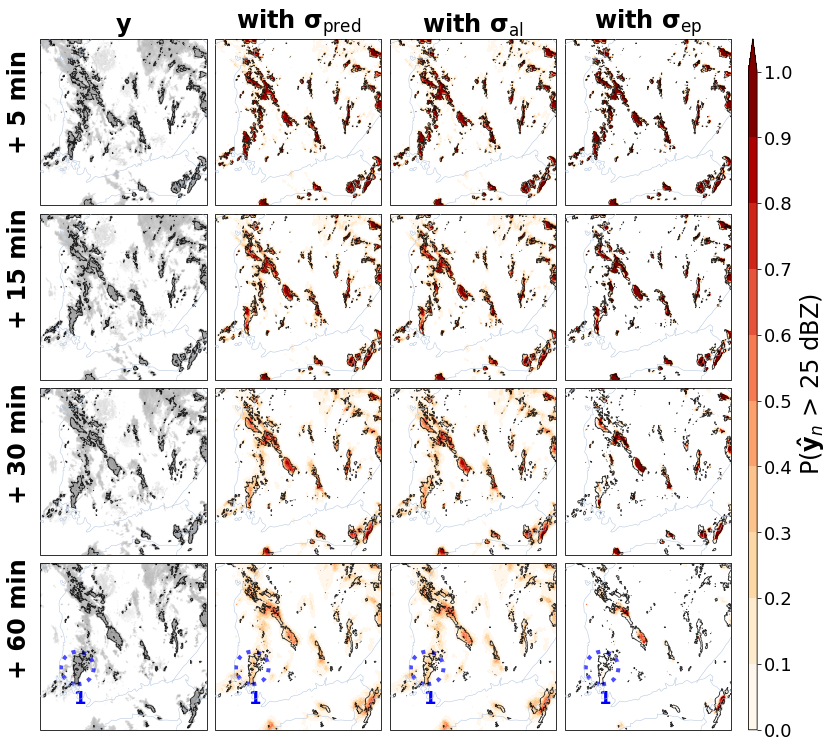

In [62]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(4*3,4*3), subplot_kw={"projection" : crs})
fs = 24
fs_tick = 18

cmap_prob, norm_prob, clevs_prob, clevs_str_prob = get_colormap(ptype="prob")
cmap.set_bad('darkgray',0.)
cmap_prob.set_bad('dimgrey',1.)

ax[0,0].set_title("$\mathbf{y}$", fontsize=fs, fontweight="semibold")
ax[0,1].set_title("with $\mathbf{\sigma}_{\mathrm{pred}}$", fontsize=fs, fontweight="semibold")
ax[0,2].set_title("with $\mathbf{\sigma}_{\mathrm{al}}$", fontsize=fs, fontweight="semibold")
ax[0,3].set_title("with $\mathbf{\sigma}_{\mathrm{ep}}$", fontsize=fs, fontweight="semibold")

obses_over_25 = obses.copy()
obses_over_25[obses_over_25 < 25.0] = np.nan

for i,lt in enumerate([0,2,5,11]):

    for j in range(4):
        ax[i,j].set_extent((x0, x1, y0, y1), crs)
        edgecolor = "lightsteelblue"
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("physical", "coastline", scale=cartopy_scale,
                edgecolor=edgecolor, facecolor="none", linewidth=0.5), zorder=100)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("cultural", "admin_0_boundary_lines_land",
                scale=cartopy_scale, edgecolor=edgecolor, facecolor="none", linewidth=0.5),
                zorder=100)

    ax[i,0].imshow(obses[lt], extent=(x0, x1, y0, y1), cmap="binary", alpha=0.5)
    #im_obs = ax[i,0].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool")
    ax[i,0].contour(obses[lt], [25], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)

    
    ax[i,1].imshow(probs_bcnn[lt,1], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,1].contour(obses[lt], [25], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,1].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)

    ax[i,2].imshow(probs_al[lt,1], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,2].contour(obses[lt], [25], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,2].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)
    im_p = ax[i,3].imshow(probs_ep[lt,1], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,3].contour(obses[lt], [25], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,3].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)

#circles
for j in range(4):
    ax[3,j].add_patch(plt.Circle((240000, 300000), 50000, edgecolor='blue',facecolor='none',linestyle=':',linewidth=4,alpha=0.7))
    ax[3,j].text(240000-10000, 300000-110000, "1", color="blue",fontweight="bold",fontsize=18)
    
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.05,
    hspace=0.05)
    
cbar_p_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
#cbar_g_ax = fig.add_axes([0.03, 0.1, 0.01, 0.8])
cbar_p = fig.colorbar(im_p, ticks=clevs_prob, spacing="uniform", extend="max",cax=cbar_p_ax)
cbar_p.ax.set_yticklabels(clevs_str_prob)
#cbar_g = fig.colorbar(im_obs, spacing="uniform", extend="max",cax=cbar_g_ax)
cbar_p.set_label("P($\mathbf{\hat{y}}_n$ > 25 dBZ)", fontsize=fs)
#cbar_g.set_label(f"Precipitation intensity over threshold [dBZ]", fontsize=fs)
#cbar_g.ax.yaxis.set_label_position('left')
cbar_p_ax.tick_params(labelsize=fs_tick)
#cbar_g_ax.tick_params(labelsize=fs_tick)


# lead time labels
grid = plt.GridSpec(4, 4)
time_x =-0.01
time_y = 0.30
create_subtitle(fig, grid[0,::], '+ 5 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[1,::], '+ 15 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[2,::], '+ 30 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[3,::], '+ 60 min', pos="left", x=time_x, y=time_y, fontsize=fs)

#fig.tight_layout()
#if SAVE:
fig.savefig(OUTPUT_FOLDER / "case_exc_vs_type_25.png", bbox_inches='tight')


In [53]:
obses_over_15 = obses.copy()
obses_over_15[obses_over_15 < 15.0] = np.nan

obses_over_35 = obses.copy()
obses_over_35[obses_over_35 < 35.0] = np.nan

obses_over_45 = obses.copy()
obses_over_45[obses_over_45 < 45.0] = np.nan

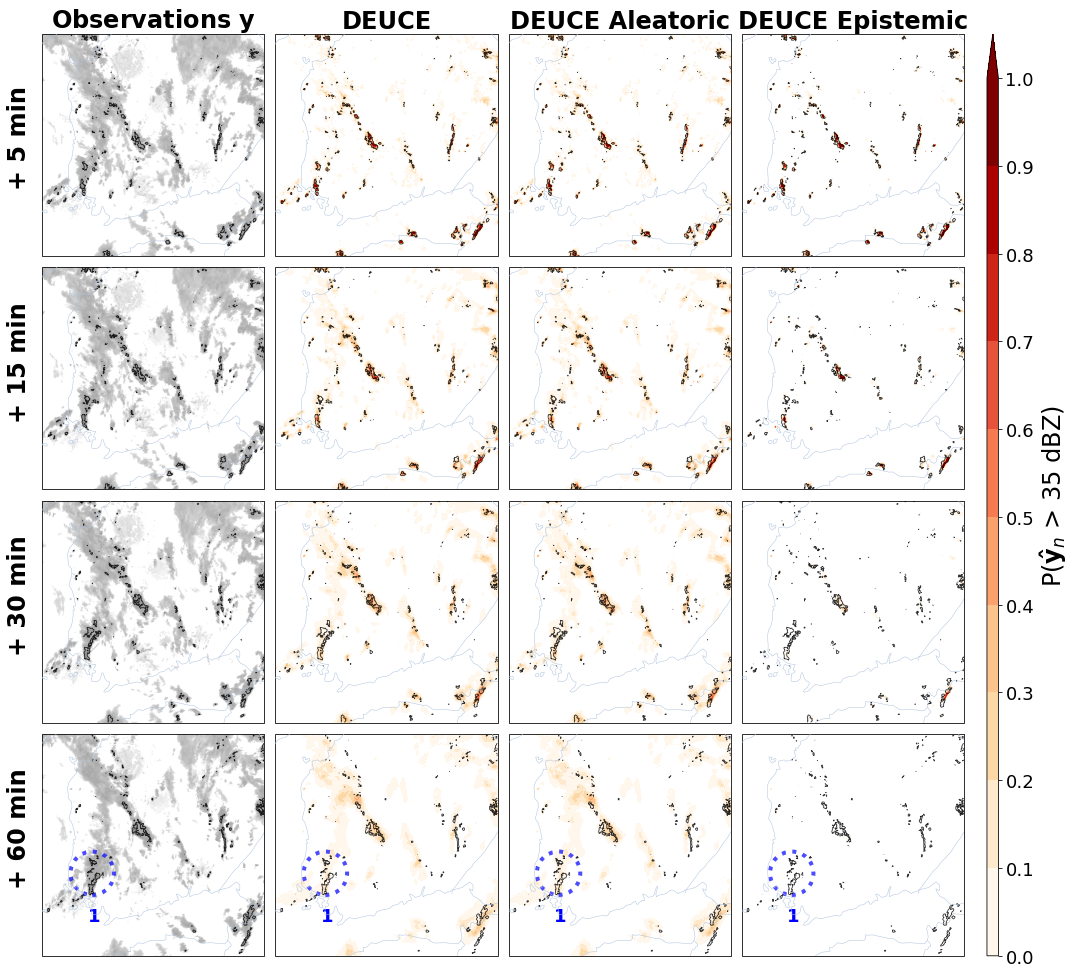

In [54]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(4*4,4*4), subplot_kw={"projection" : crs})
fs = 24
fs_tick = 18

cmap_prob, norm_prob, clevs_prob, clevs_str_prob = get_colormap(ptype="prob")
cmap.set_bad('darkgray',0.)
cmap_prob.set_bad('dimgrey',1.)

ax[0,0].set_title("Observations $\mathbf{y}$", fontsize=fs, fontweight="semibold")
ax[0,1].set_title("DEUCE", fontsize=fs, fontweight="semibold")
ax[0,2].set_title("DEUCE Aleatoric", fontsize=fs, fontweight="semibold")
ax[0,3].set_title("DEUCE Epistemic", fontsize=fs, fontweight="semibold")

#obses_over_25 = obses.copy()
#obses_over_25[obses_over_25 < 25.0] = np.nan

for i,lt in enumerate([0,2,5,11]):

    for j in range(4):
        ax[i,j].set_extent((x0, x1, y0, y1), crs)
        edgecolor = "lightsteelblue"
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("physical", "coastline", scale=cartopy_scale,
                edgecolor=edgecolor, facecolor="none", linewidth=0.5), zorder=100)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("cultural", "admin_0_boundary_lines_land",
                scale=cartopy_scale, edgecolor=edgecolor, facecolor="none", linewidth=0.5),
                zorder=100)

    ax[i,0].imshow(obses[lt], extent=(x0, x1, y0, y1), cmap="binary", alpha=0.5)
    #im_obs = ax[i,0].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool")
    ax[i,0].contour(obses[lt], [35], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)

    
    ax[i,1].imshow(probs_bcnn[lt,2], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,1].contour(obses[lt], [35], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,1].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)

    ax[i,2].imshow(probs_al[lt,2], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,2].contour(obses[lt], [35], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,2].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)
    im_p = ax[i,3].imshow(probs_ep[lt,2], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,3].contour(obses[lt], [35], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,3].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)

#circles
for j in range(4):
    ax[3,j].add_patch(plt.Circle((240000, 300000), 50000, edgecolor='blue',facecolor='none',linestyle=':',linewidth=4,alpha=0.7))
    ax[3,j].text(240000-10000, 300000-110000, "1", color="blue",fontweight="bold",fontsize=18)
    
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.05,
    hspace=0.05)
    
cbar_p_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
#cbar_g_ax = fig.add_axes([0.03, 0.1, 0.01, 0.8])
cbar_p = fig.colorbar(im_p, ticks=clevs_prob, spacing="uniform", extend="max",cax=cbar_p_ax)
cbar_p.ax.set_yticklabels(clevs_str_prob)
#cbar_g = fig.colorbar(im_obs, spacing="uniform", extend="max",cax=cbar_g_ax)
cbar_p.set_label("P($\mathbf{\hat{y}}_n$ > 35 dBZ)", fontsize=fs)
#cbar_g.set_label(f"Precipitation intensity over threshold [dBZ]", fontsize=fs)
#cbar_g.ax.yaxis.set_label_position('left')
cbar_p_ax.tick_params(labelsize=fs_tick)
#cbar_g_ax.tick_params(labelsize=fs_tick)


# lead time labels
grid = plt.GridSpec(4, 4)
time_x =-0.01
time_y = 0.30
create_subtitle(fig, grid[0,::], '+ 5 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[1,::], '+ 15 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[2,::], '+ 30 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[3,::], '+ 60 min', pos="left", x=time_x, y=time_y, fontsize=fs)

#fig.tight_layout()
#if SAVE:
fig.savefig(OUTPUT_FOLDER / "case_exc_vs_type_35.pdf", bbox_inches='tight')


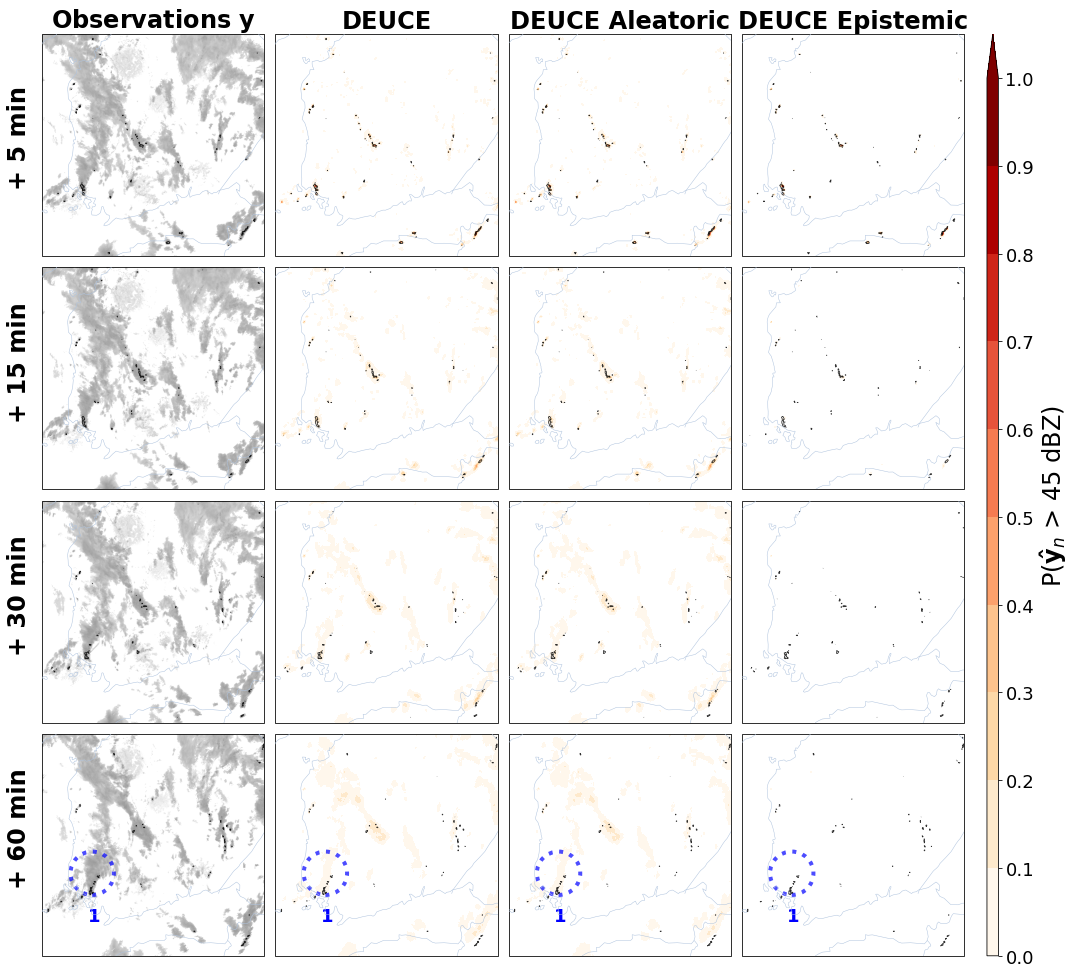

In [55]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(4*4,4*4), subplot_kw={"projection" : crs})
fs = 24
fs_tick = 18

cmap_prob, norm_prob, clevs_prob, clevs_str_prob = get_colormap(ptype="prob")
cmap.set_bad('darkgray',0.)
cmap_prob.set_bad('dimgrey',1.)

ax[0,0].set_title("Observations $\mathbf{y}$", fontsize=fs, fontweight="semibold")
ax[0,1].set_title("DEUCE", fontsize=fs, fontweight="semibold")
ax[0,2].set_title("DEUCE Aleatoric", fontsize=fs, fontweight="semibold")
ax[0,3].set_title("DEUCE Epistemic", fontsize=fs, fontweight="semibold")

#obses_over_25 = obses.copy()
#obses_over_25[obses_over_25 < 25.0] = np.nan

for i,lt in enumerate([0,2,5,11]):

    for j in range(4):
        ax[i,j].set_extent((x0, x1, y0, y1), crs)
        edgecolor = "lightsteelblue"
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("physical", "coastline", scale=cartopy_scale,
                edgecolor=edgecolor, facecolor="none", linewidth=0.5), zorder=100)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("cultural", "admin_0_boundary_lines_land",
                scale=cartopy_scale, edgecolor=edgecolor, facecolor="none", linewidth=0.5),
                zorder=100)

    ax[i,0].imshow(obses[lt], extent=(x0, x1, y0, y1), cmap="binary", alpha=0.5)
    #im_obs = ax[i,0].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool")
    ax[i,0].contour(obses[lt], [45], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)

    
    ax[i,1].imshow(probs_bcnn[lt,3], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,1].contour(obses[lt], [45], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,1].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)

    ax[i,2].imshow(probs_al[lt,3], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,2].contour(obses[lt], [45], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,2].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)
    im_p = ax[i,3].imshow(probs_ep[lt,3], extent=(x0, x1, y0, y1), cmap=cmap_prob, alpha=1, norm=norm_prob)
    ax[i,3].contour(obses[lt], [45], extent=(x0, x1, y0, y1), colors = ["k"], linewidths=[0.8], origin = "image", alpha = 0.8)
    #ax[i,3].imshow(obses_over_25[lt], extent=(x0, x1, y0, y1), cmap="cool", alpha=0.5)

#circles
for j in range(4):
    ax[3,j].add_patch(plt.Circle((240000, 300000), 50000, edgecolor='blue',facecolor='none',linestyle=':',linewidth=4,alpha=0.7))
    ax[3,j].text(240000-10000, 300000-110000, "1", color="blue",fontweight="bold",fontsize=18)
    
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.05,
    hspace=0.05)
    
cbar_p_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])
#cbar_g_ax = fig.add_axes([0.03, 0.1, 0.01, 0.8])
cbar_p = fig.colorbar(im_p, ticks=clevs_prob, spacing="uniform", extend="max",cax=cbar_p_ax)
cbar_p.ax.set_yticklabels(clevs_str_prob)
#cbar_g = fig.colorbar(im_obs, spacing="uniform", extend="max",cax=cbar_g_ax)
cbar_p.set_label("P($\mathbf{\hat{y}}_n$ > 45 dBZ)", fontsize=fs)
#cbar_g.set_label(f"Precipitation intensity over threshold [dBZ]", fontsize=fs)
#cbar_g.ax.yaxis.set_label_position('left')
cbar_p_ax.tick_params(labelsize=fs_tick)
#cbar_g_ax.tick_params(labelsize=fs_tick)


# lead time labels
grid = plt.GridSpec(4, 4)
time_x =-0.01
time_y = 0.30
create_subtitle(fig, grid[0,::], '+ 5 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[1,::], '+ 15 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[2,::], '+ 30 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[3,::], '+ 60 min', pos="left", x=time_x, y=time_y, fontsize=fs)

#fig.tight_layout()
#if SAVE:
fig.savefig(OUTPUT_FOLDER / "case_exc_vs_type_45.pdf", bbox_inches='tight')
